In [14]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer
from data_pipelines.data_manipulation import DataManipulation
from dl_models.xgboost_forecaster import XgboostForecaster
from logger.logger import Logger


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [15]:
SYMBOL = 'BTC-USD'
SYMBOL_NAME = 'Bitcoin'
SYMBOL_CUT = 'btc'
scale = 1
range_list = [i for i in range(5,21)]
range_list = [i*scale for i in range_list]
interval = '1d'
start_date = '2020-06-30'
end_date = '2022-07-01'
source = 'yahoo'
LOG_PATH = '../logger' + os.sep + "logs"
LOG_FILE_NAME_PREFIX = f"log_{SYMBOL_CUT}_{start_date}_{end_date}"

logger = Logger(LOG_PATH, LOG_FILE_NAME_PREFIX)
tsa = TweetSentimentAnalyzer()
data = DataManipulation(SYMBOL, source, range_list, start_date=start_date, 
                        end_date=end_date, interval=interval, scale=scale, 
                        prefix_path='..', saved_to_csv=True,
                        logger=logger)
df_price = data.df.copy()

1 ) 22-12-2022 22_33_28 MainThread INFO\ Initialized logging at path ../logger/logs/log_btc_2020-06-30_2022-07-01_22-12-2022_22_33_28.log
2 ) 22-12-2022 22_33_28 MainThread DEBUG\ Get data from local file ../data/outputs/data_ind/BTC-USD/BTC-USD_df_2020-06-30_2022-07-01_1d.csv


In [16]:
df_price_ext = data.extract_features()
close_col = df_price.loc['2021-01-01':'2022-06-27',['close','volume']].copy()

3 ) 22-12-2022 22_33_28 MainThread DEBUG\ Get features matrix from ../data/outputs/feature_data/BTC-USD BTC-USD_df_2020-06-30_2022-07-01_1d.csv


In [17]:
sent_tweets = pd.read_csv('btc_archieve/btc_daily_sent_score.csv')
sent_tweets.Date = pd.to_datetime(sent_tweets.Date)
sent_tweets.set_index('Date', inplace=True, drop=True)

In [ ]:
sent_tweets.index = sent_tweets.index.tz_convert(None)

In [ ]:
df_final = tsa.concat_ohlc_compound_score(df_price_ext, sent_tweets)
df_final = df_final.loc['2021-01-01':,:].copy()
df_final.dropna(inplace=True)

Concantenation for sentiment score tweets and indicator MAtrix data


In [ ]:
df_final.shape

(543, 211)

Text(0.5, 1.0, 'Bitcoin Proce')

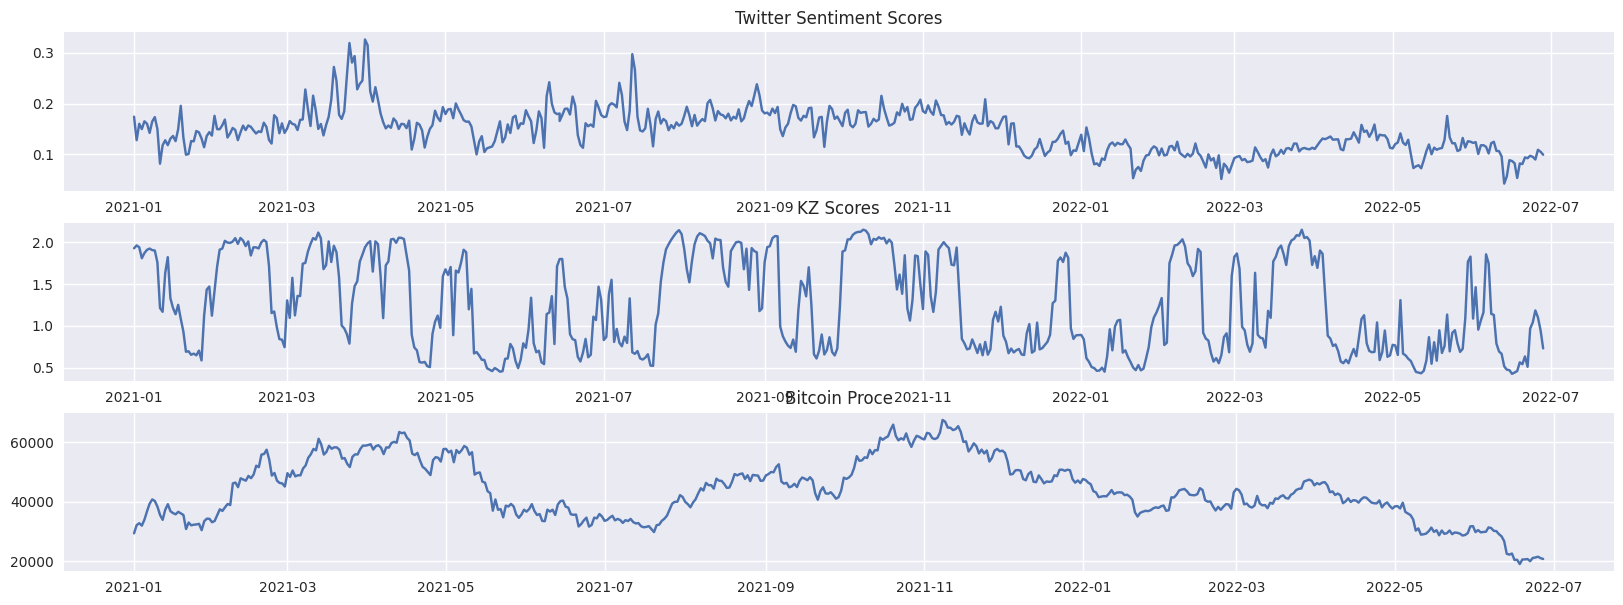

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(20,7))
ax1.plot(df_final.compound_total)
ax1.set_title('Twitter Sentiment Scores')
ax2.plot(df_final.index, df_final.kz_score)
ax2.set_title('KZ Scores')
ax3.plot(close_col.index, close_col.close)
ax3.set_title('Bitcoin Proce')

In [ ]:
df = df_final.copy()
df.reset_index(drop=True, inplace=True)
df.head()

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,feature_label,kz_score,compound_total
0,0,1,1,1,1,1,0,0,3,3,...,1,1,1,0,1,1,1,1.0000,1.9276,0.1744
1,0,1,1,1,1,1,0,0,3,3,...,1,1,1,1,0,1,1,1.0000,1.9622,0.1280
2,0,1,1,1,1,1,0,0,3,3,...,1,1,1,1,1,0,1,0.0000,1.9399,0.1604
3,0,1,1,1,1,1,0,0,3,3,...,1,1,1,1,1,1,0,1.0000,1.8085,0.1499
4,0,1,1,1,1,1,0,0,3,3,...,1,1,1,1,1,1,1,1.0000,1.8705,0.1652


In [ ]:
y = df_final.log_return
X = df_final.drop(columns=['log_return'], axis=1)

Creating X_train, X_test, y_train, y_test, evalset
[0]	validation_0-logloss:0.59716	validation_1-logloss:0.58794
[1]	validation_0-logloss:0.52769	validation_1-logloss:0.50999
[2]	validation_0-logloss:0.48151	validation_1-logloss:0.47356
[3]	validation_0-logloss:0.45080	validation_1-logloss:0.43640
[4]	validation_0-logloss:0.42563	validation_1-logloss:0.40484
[5]	validation_0-logloss:0.40674	validation_1-logloss:0.39072
[6]	validation_0-logloss:0.39346	validation_1-logloss:0.37472
[7]	validation_0-logloss:0.38303	validation_1-logloss:0.35886
[8]	validation_0-logloss:0.37398	validation_1-logloss:0.35625
[9]	validation_0-logloss:0.36509	validation_1-logloss:0.35006
[10]	validation_0-logloss:0.35864	validation_1-logloss:0.35328
[11]	validation_0-logloss:0.35302	validation_1-logloss:0.35222
[12]	validation_0-logloss:0.34767	validation_1-logloss:0.34186
[13]	validation_0-logloss:0.34301	validation_1-logloss:0.33954
[14]	validation_0-logloss:0.33897	validation_1-logloss:0.34521
[15]	validatio

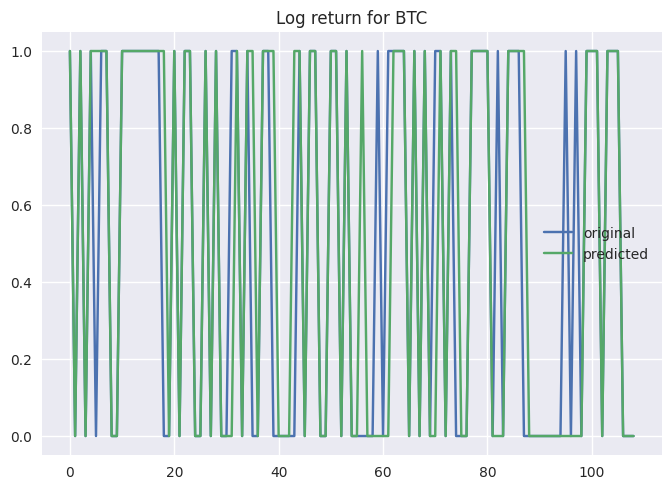

In [23]:
y = (df_final.log_return > 0).astype(int)                            #df_final.feature_label
#df_final.drop(columns=['feature_label'], axis=1)
eval_metric = 'logloss'
eval_metric = None
xgb = XgboostForecaster(objective='binary', n_estimators=100, eta=0.3, max_depth=1, 
                    tree_method='gpu_hist', cv=10, eval_metric='logloss')
xgb.create_train_test_data(X, y, test_size=0.2)
xgb.fit()
xgb.save_model('model_reg_daily.json')
score = xgb.get_score()
#xgb.plot_learning_curves()
xgb.get_model_names()
best_params = xgb.bestparams_gridcv([100, 200], [0.1], [1, 3], verbose=3)


ytest = xgb.y_test
ypred_reg = xgb.model.predict(xgb.X_test)
x_ax = range(len(xgb.y_test))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred_reg, label="predicted")
plt.title("Log return for BTC")
plt.legend()
plt.show()
#yhat = (xgb.model.predict(xgb.X_test) > 0).astype(int)
#y_ = (xgb.y_test > 0).astype(int)
#accuracy = accuracy_score(yhat, y_)
#print('Accuracy: %.3f' % accuracy)


{'st_tema_5': 0.43704987, 'st_stoch': 0.1772543, 'candle_label': 0.08421614, 'st_tema_6': 0.045235407, 'st_rsi_5': 0.02491374, 'st_rsi_7': 0.015310271, 'st_mfi_19': 0.013119303, 'st_mfi_5': 0.012832385, 'st_adx_12': 0.012612944, 'weekday': 0.0119792465}


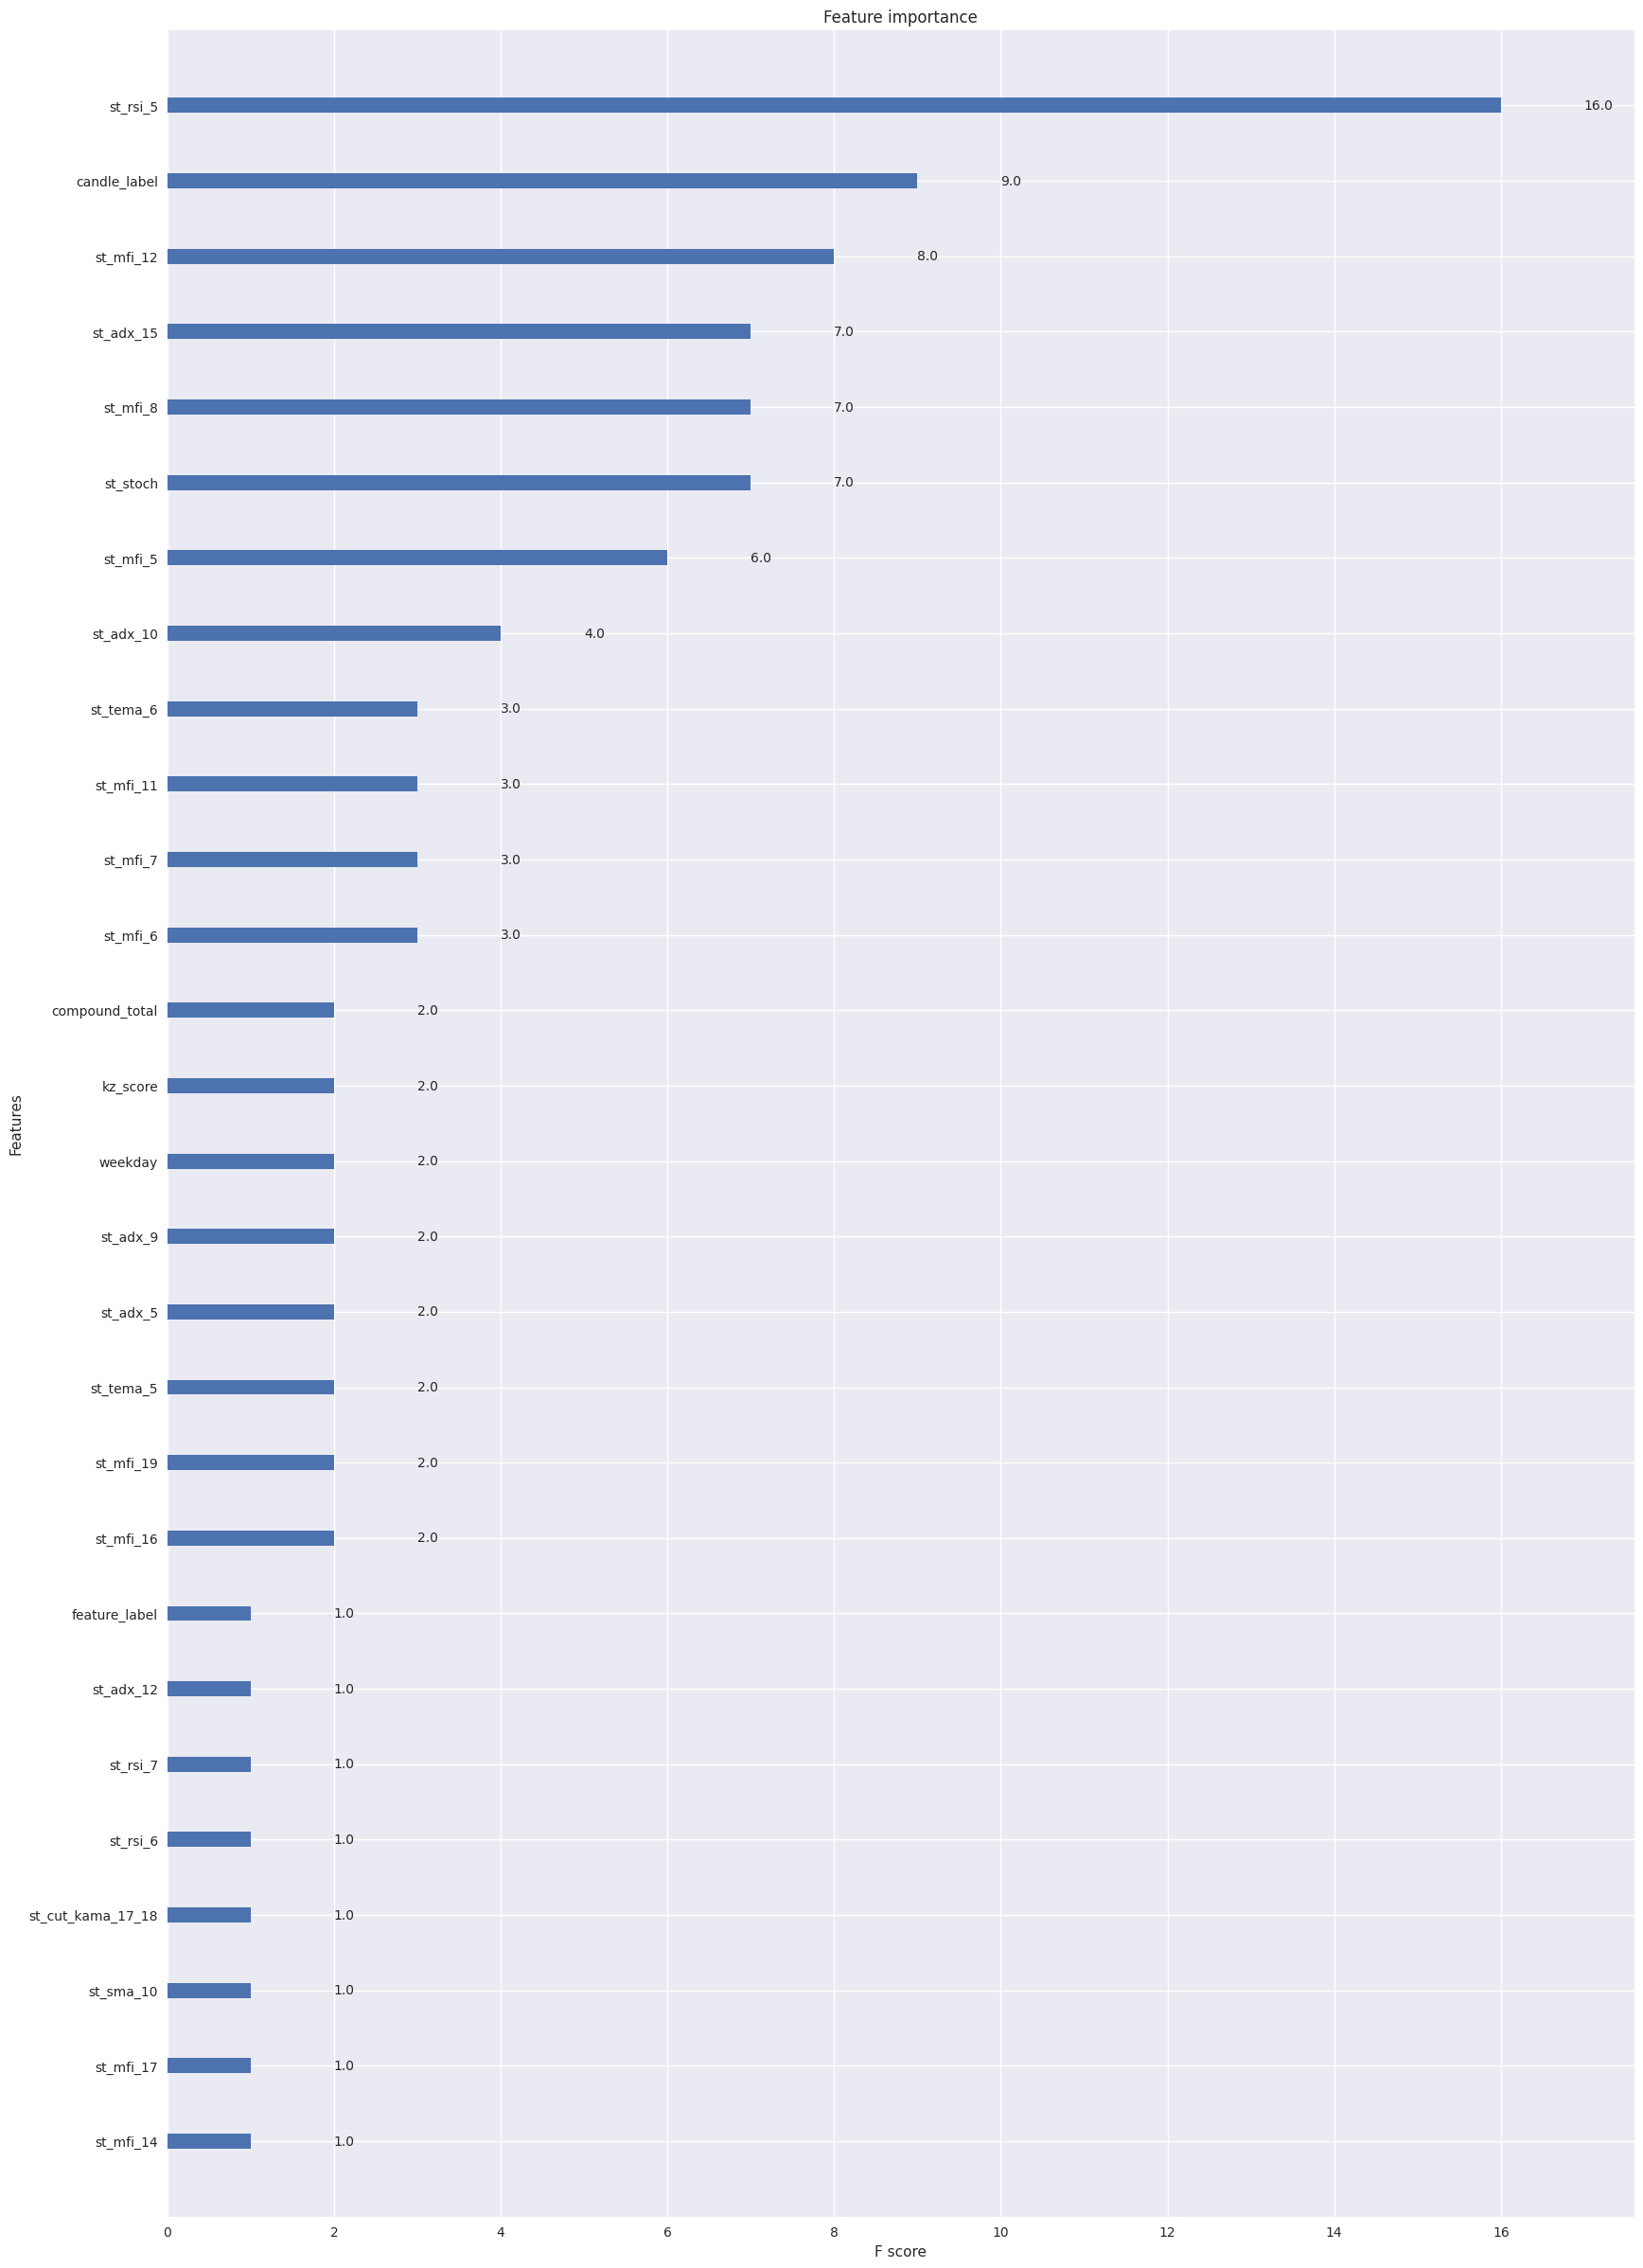

In [24]:
n_feat = xgb.get_n_importance_features(10)
print(n_feat)

xgb.plot_fature_importance()

Learning curves ploting and saved


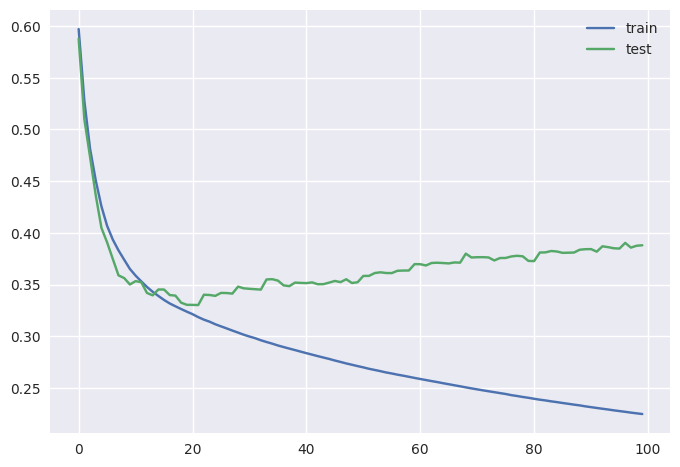

In [25]:
xgb.plot_learning_curves()